# Black Scholes PDE finite difference method

For many options, we cannot find a closed form solution of the superhedging price. In these cases, we can use numerical methods to approximate the solution. In this notebook, we will use the finite difference method to approximate the solution to the Black Scholes PDE.

## Black Scholes PDE

The Black Scholes PDE occurs when applying Ito's lemma to the discounted price process of an option.

$$
\frac{\partial\pi}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2\pi}{\partial S^2} + rS\frac{\partial\pi}{\partial S} - r\pi = 0
$$

We first transform the PDE into the heat equation and then use finite differences to approximate the solution.

$\textbf{Theory from a lecture at LMU by Dr. Ari-Pekka Perkkiö}$

In [30]:
import numpy as np
import matplotlib.pyplot as plt

import fima

In [31]:
r = 0
sigma = 1
T = 1
K = 100

N = 10000
J = 1000

In [32]:
def europeanCallPayoff(S, K):
    return np.maximum(S - K, 0)

def europeanPutPayoff(S, K):
    return np.maximum(K - S, 0)

def quadraticOptionPayoff(x):
    return x**2

In [33]:
def finiteDifferences(N, J, quadratic_payoff, payoff):
    xmax = 10000
    xmin = 0.0001

    u = np.zeros((J, N+1))

    a = 0.5*(2*r/(sigma*sigma)-1)
    b = 0.25*(2*r/(sigma*sigma)+1)**2
    Tau = 0.5*sigma*sigma*T
    ymax = np.log(xmax)
    ymin = np.log(xmin)
    delta_tau = Tau/N
    delta_y = (ymax-ymin)/(J-1)

    taugrid = np.linspace(0, Tau, N+1)
    ygrid = np.linspace(ymin, ymax, J)

    if delta_tau > 0.5*delta_y**2:
        print("Error: delta_tau is too large")
        print("delta_tau = ", delta_tau)
        print("0.5*delta_y^2 = ", 0.5*delta_y**2)

    u[:, 0] = np.exp(a*ygrid)*payoff(np.exp(ygrid))
    u[0, 0] = np.exp(a*ymin)*payoff(0)

    s = delta_tau/(delta_y**2)
    offdiag=s * np.ones(J-1)
    diag=(1-2*s)*np.ones(J)

    A = np.diag(diag) + np.diag(offdiag, -1) + np.diag(offdiag, 1)

    for n in range(1, N+1):
        u[:, n] = A.dot(u[:, n-1])
        u[0, n] = np.exp((b-r*2/sigma**2)*taugrid[n]+a*ymin)*payoff(0)
        if quadratic_payoff:
            u[J-1, n] = np.exp(a*ymax+(b+r*2/sigma**2+2)*taugrid[n])*payoff(np.exp(ymax))
        else:
            u[J-1, n] = np.exp(a*ymax+b*taugrid[n])*payoff(np.exp(ymax))

    xgrid = np.exp(ygrid)
    timegrid = np.linspace(0, T, N+1)

    meshtau, meshy = np.meshgrid(taugrid, ygrid)

    pi = np.flip(np.exp(-a*meshy-b*meshtau)*u, 1)

    return timegrid, xgrid, pi

In [34]:
timegrid_eco, xgrid_eco, pi_eco = finiteDifferences(N, J, False, lambda x : europeanCallPayoff(x, K))

In [35]:
pi_analytical = np.zeros((J, N+1))
for n in range(N+1):
    pi_analytical[:, n] = fima.BS_call_price(timegrid_eco[n], xgrid_eco, K, r, sigma, T)

In [36]:
lower_index = np.argmax(xgrid_eco > 10)
upper_index = np.argmax(xgrid_eco > 300)

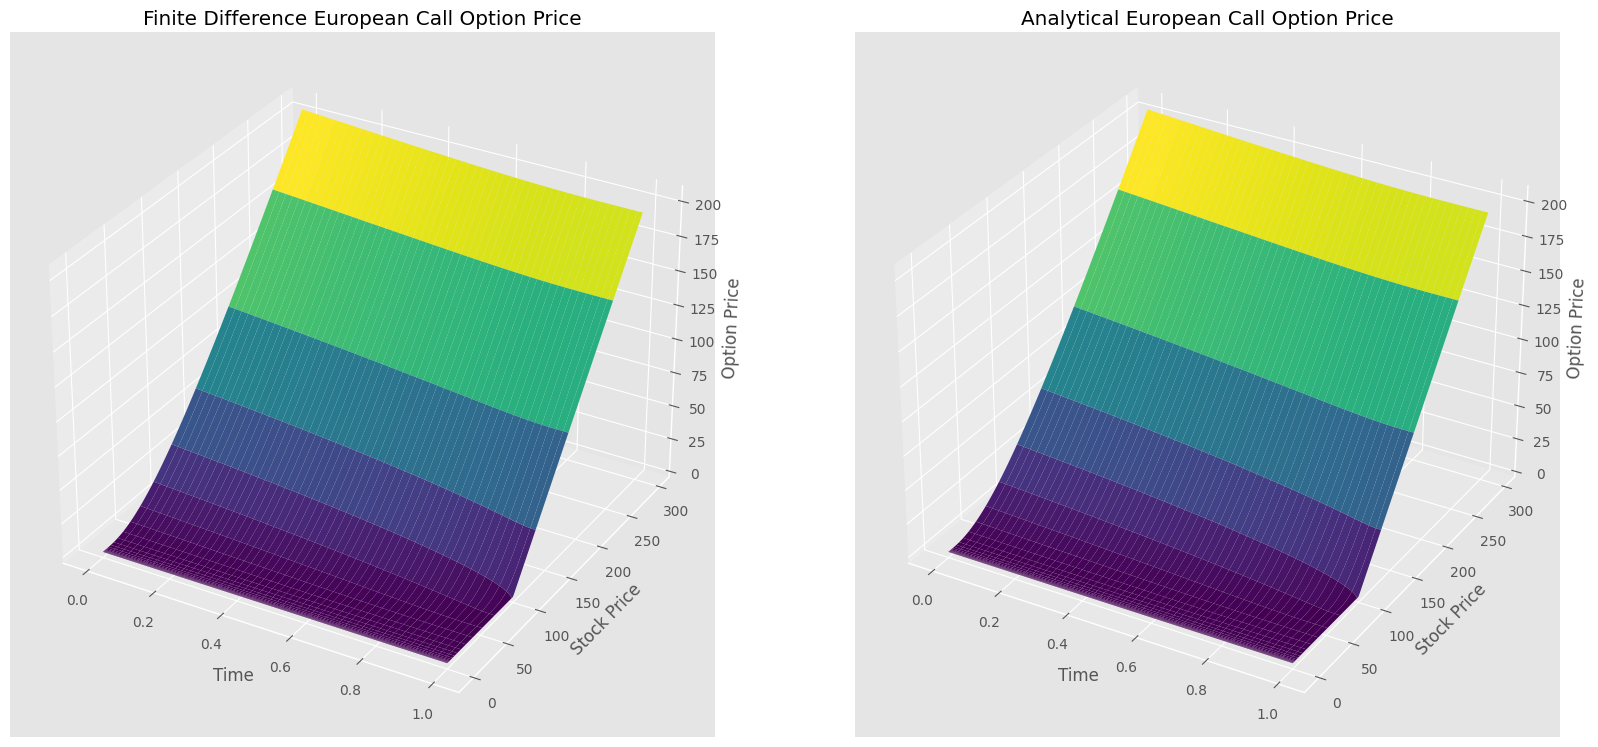

In [37]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')

X, Y = np.meshgrid(timegrid_eco, xgrid_eco[:upper_index])
ax.plot_surface(X, Y, pi_eco[:upper_index, :], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Option Price')
ax.set_title('Finite Difference European Call Option Price')

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(X, Y, pi_analytical[:upper_index, :], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Option Price')
ax.set_title('Analytical European Call Option Price');

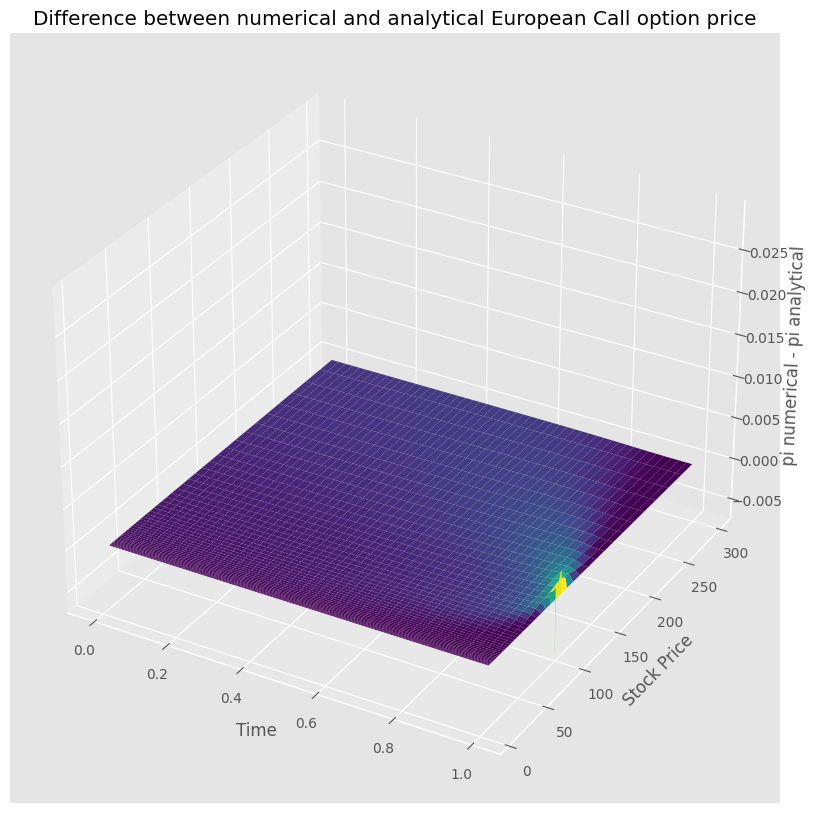

In [38]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X, Y = np.meshgrid(timegrid_eco, xgrid_eco[lower_index:upper_index])
ax.plot_surface(X, Y, pi_eco[lower_index:upper_index, :] - pi_analytical[lower_index:upper_index, :], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('pi numerical - pi analytical')
ax.set_title('Difference between numerical and analytical European Call option price');

In [39]:
pi_final_numerical = pi_eco[:, 0]
pi_final_analytical = fima.BS_call_price(0, xgrid_eco, K, r, sigma, T)

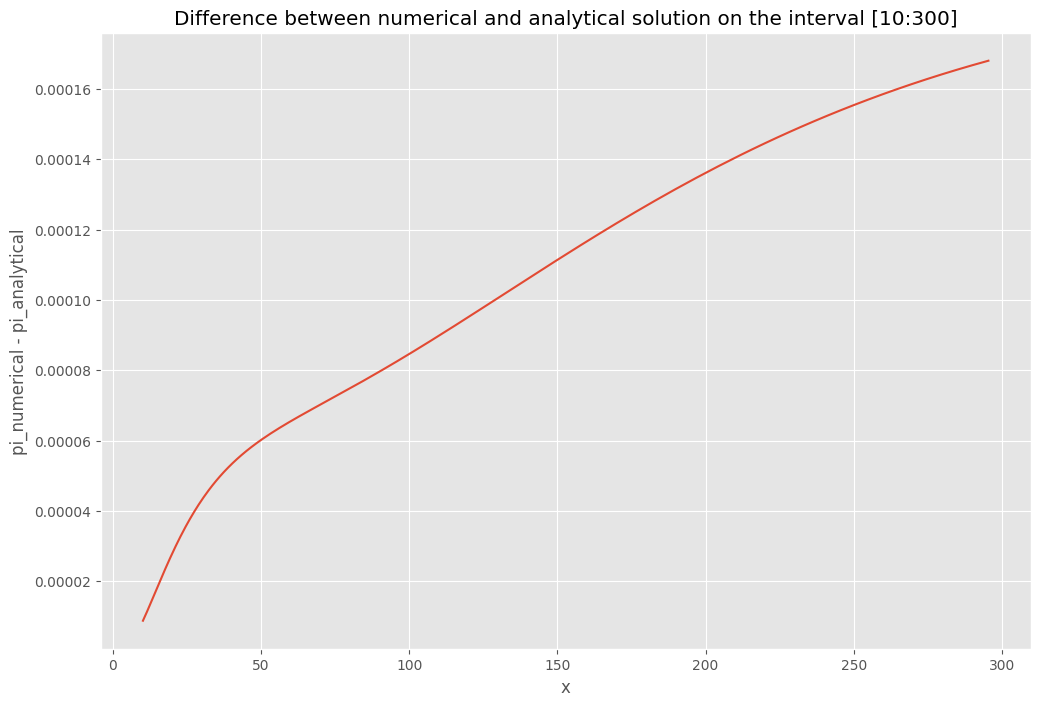

In [40]:
plt.plot(xgrid_eco[lower_index:upper_index], pi_final_numerical[lower_index:upper_index] - pi_final_analytical[lower_index:upper_index])
plt.title("Difference between numerical and analytical solution on the interval [10:300]")
plt.xlabel("x")
plt.ylabel("pi_numerical - pi_analytical");

In [41]:
error = np.abs((pi_final_numerical[lower_index:upper_index] - pi_final_analytical[lower_index:upper_index])/pi_final_analytical[lower_index:upper_index])
print("relative error: ", np.mean(error))

relative error:  1.6111463721781733e-05


In [42]:
timegrid_epo, xgrid_epo, pi_epo = finiteDifferences(N, J, False, lambda x : europeanPutPayoff(x, K))

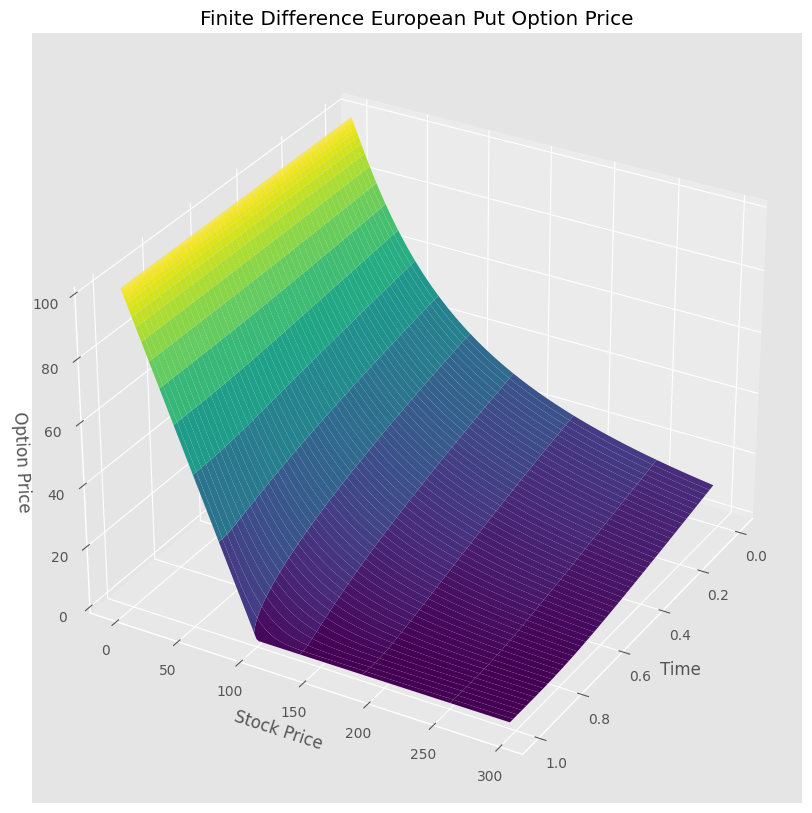

In [43]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X, Y = np.meshgrid(timegrid_epo, xgrid_epo[:upper_index])
ax.plot_surface(X, Y, pi_epo[:upper_index, :], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Option Price')
ax.set_title('Finite Difference European Put Option Price')
ax.view_init(30, 30);

In [44]:
timegrid_qo, xgrid_qo, pi_qo = finiteDifferences(N, J, True, quadraticOptionPayoff)

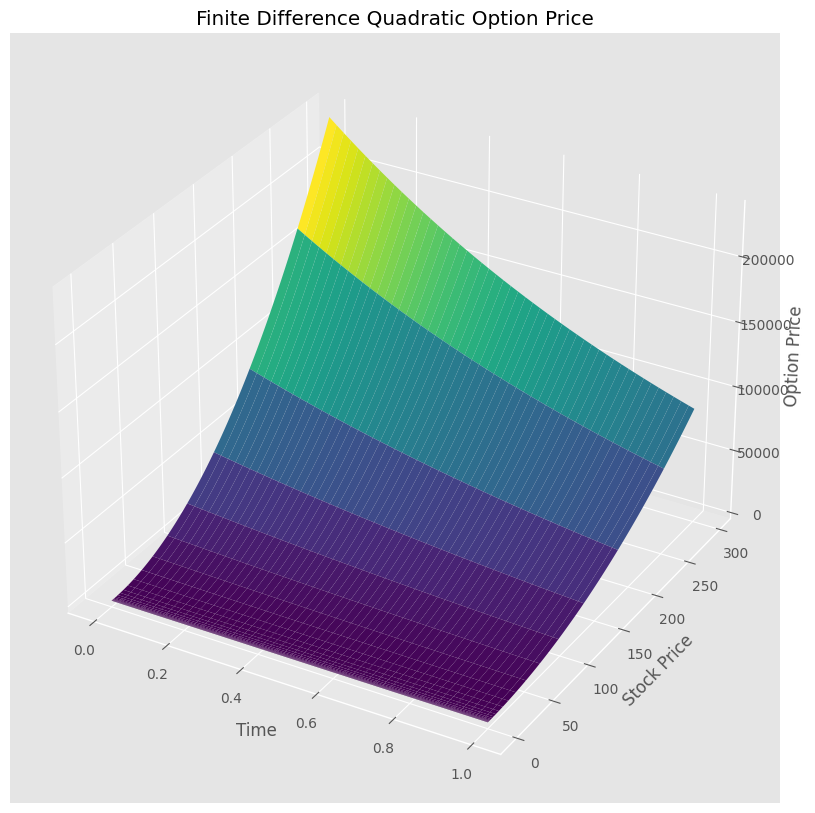

In [45]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X, Y = np.meshgrid(timegrid_qo, xgrid_qo[:upper_index])
ax.plot_surface(X, Y, pi_qo[:upper_index, :], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Option Price')
ax.set_title('Finite Difference Quadratic Option Price');

In [46]:
scale_x = np.zeros(J)
scale_x[0] = 1/(xgrid_eco[0] - xgrid_eco[1])

for j in range(1, J-1):
    scale_x[j] = 1/(xgrid_eco[j+1] - xgrid_eco[j-1])

scale_x[J-1] = 1/(xgrid_eco[J-1] - xgrid_eco[J-2])

In [47]:
B_x = np.diag(np.ones(J-1), 1) - np.diag(np.ones(J-1), -1)
B_x[0, 0] = -1
B_x[J-1, J-1] = 1

for j in range(J):
    B_x[j, :] = B_x[j, :]*scale_x[j]

In [48]:
delta = np.dot(B_x, pi_eco)

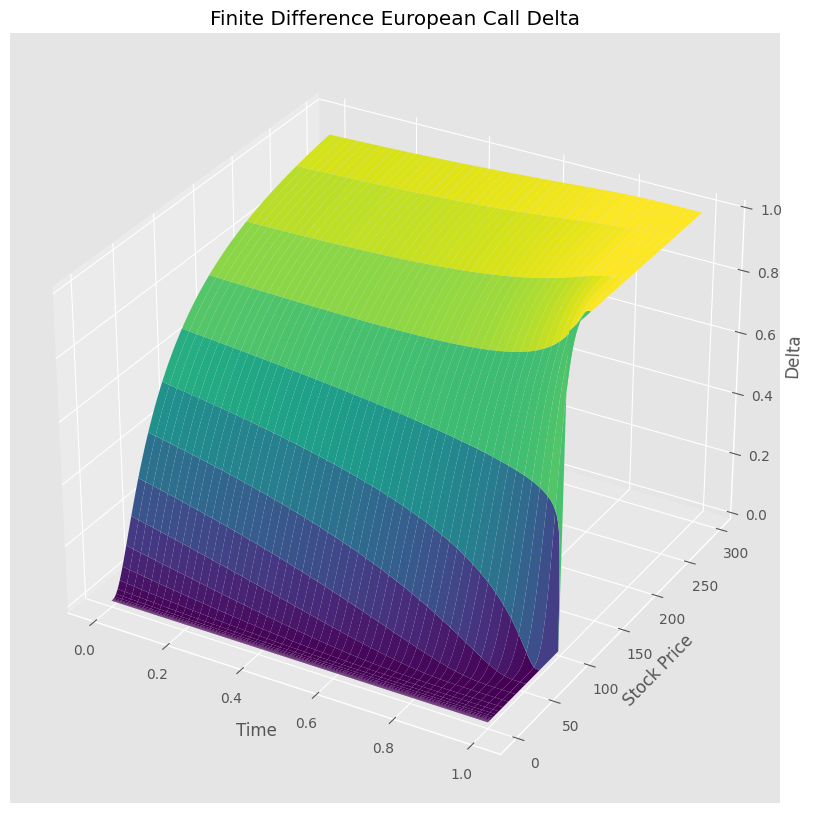

In [49]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X, Y = np.meshgrid(timegrid_eco, xgrid_eco[:upper_index])
ax.plot_surface(X, Y, delta[:upper_index, :], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Delta')
ax.set_title('Finite Difference European Call Delta');

In [50]:
scale_t = np.zeros(N+1)
scale_t[0] = 1/(timegrid_eco[1] - timegrid_eco[0])

for n in range(1, N):
    scale_t[n] = 1/(timegrid_eco[n+1] - timegrid_eco[n-1])

scale_t[N] = 1/(timegrid_eco[N] - timegrid_eco[N-1])

In [51]:
B_t = - np.diag(np.ones(N), 1) + np.diag(np.ones(N), -1)
B_t[0, 0] = -1
B_t[N, N] = 1

B_t = B_t*scale_t

In [52]:
theta = np.dot(pi_eco,B_t)

we cut off the last 1pct of time steps because of numerical instability

In [53]:
upper_timegrid_index = np.argmax(timegrid_eco >= 0.99)

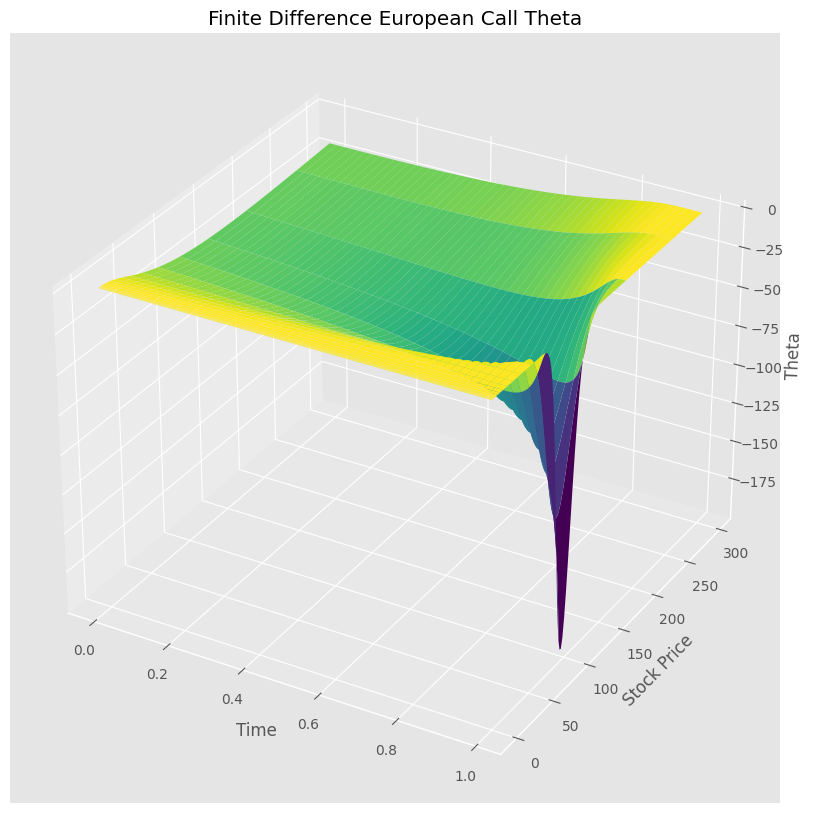

In [55]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X, Y = np.meshgrid(timegrid_eco[:upper_timegrid_index], xgrid_eco[:upper_index])
ax.plot_surface(X, Y, theta[:upper_index, :upper_timegrid_index], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Theta')
ax.set_title('Finite Difference European Call Theta');

In [56]:
gamma = np.dot(B_x, delta)

gamma_0 = gamma[:, 0]

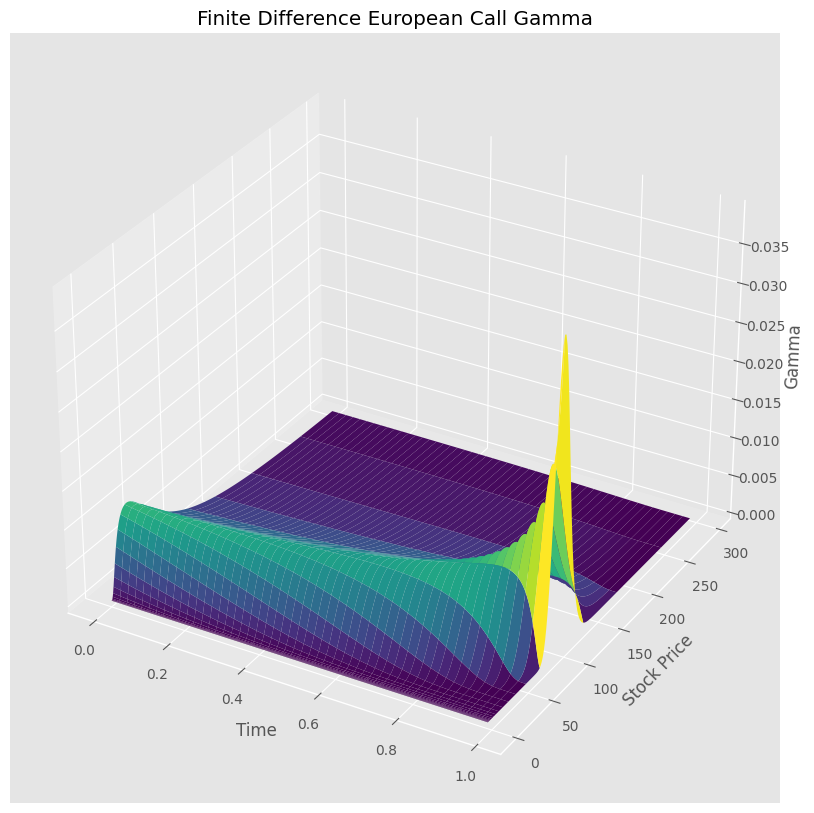

In [57]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

X, Y = np.meshgrid(timegrid_eco[:upper_timegrid_index], xgrid_eco[:upper_index])
ax.plot_surface(X, Y, gamma[:upper_index, :upper_timegrid_index], cmap = 'viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_zlabel('Gamma')
ax.set_title('Finite Difference European Call Gamma');

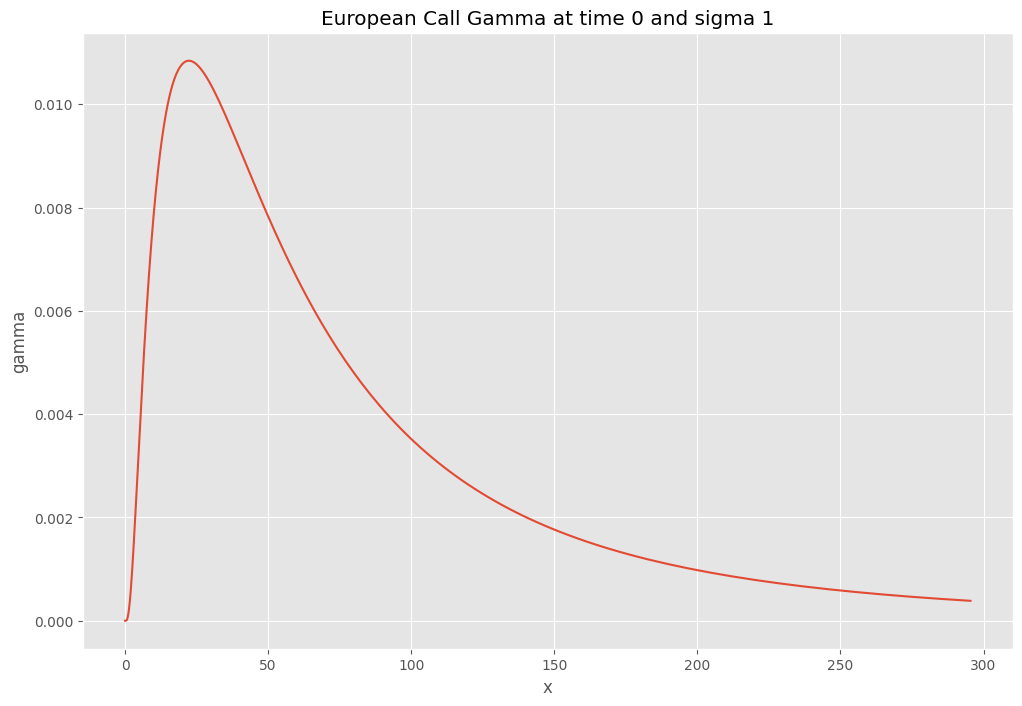

In [58]:
plt.plot(xgrid_eco[:upper_index], gamma_0[:upper_index])
plt.title("European Call Gamma at time 0 and sigma 1")
plt.xlabel("x")
plt.ylabel("gamma");